# Demonstration: VQE algorithm for excited states

In [1]:
import pennylane as qml
from pennylane import numpy as np

import sys
sys.path.insert(0, '../')
import vqe
import visualization as qplt
import qcnn as qcnn 
import general as qmlgen
import losses

from matplotlib import pyplot as plt
##############


In [7]:
Ns = range(4,13)
side = 100

path = '../data/vqes/ANNNI/'
train_index = np.arange(0,2*side-1)

In [8]:
pathplots = '../data/plots/'

In [9]:
vqes = []
for N in Ns:
    try:
        filename = 'N'+str(N)+'n'+str(side)
        vqes.append(vqe.load_vqe(path + filename) )
        print('{0} loaded sucessfully'.format(path+filename))
    except:
        print('{0} not found'.format(path+filename))

../data/vqes/ANNNI/N4n100 loaded sucessfully
../data/vqes/ANNNI/N5n100 not found
../data/vqes/ANNNI/N6n100 loaded sucessfully
../data/vqes/ANNNI/N7n100 not found
../data/vqes/ANNNI/N8n100 loaded sucessfully
../data/vqes/ANNNI/N9n100 not found
../data/vqes/ANNNI/N10n100 loaded sucessfully
../data/vqes/ANNNI/N11n100 not found
../data/vqes/ANNNI/N12n100 loaded sucessfully


In [10]:
cents = qmlgen.findC(*vqes[:-1], width = .15)

In [15]:
def get_plots(vqeclass, epoch, lr):
    qplt.show_VQE_annni(vqeclass, plot3d=False)
    plt.savefig(pathplots+'ANNNI/accuracy'+str(vqeclass.N)+'.svg')
    plt.show()

    myqcnn = qcnn.qcnn(vqeclass, qcnn.qcnn_circuit, n_outputs = 2)
    myqcnn.train(lr, epoch, train_index, losses.cross_entropy)
    show_QCNN_classificationANNNI(myqcnn, hard_thr = False, deltaeline = cents)
    plt.savefig(pathplots+'ANNNI/classification'+str(vqeclass.N)+'.svg')
    plt.show()

    show_QCNN_classificationANNNI(myqcnn, hard_thr = True, deltaeline = cents)
    plt.savefig(pathplots+'ANNNI/classification_hardthr'+str(vqeclass.N)+'.svg')
    plt.show()

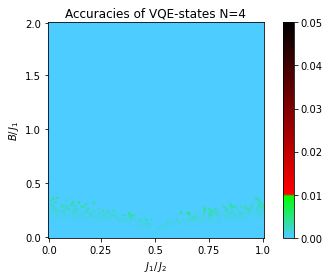

Cost: 0.1548435389995575: 100%|████████████| 1000/1000 [00:07<00:00, 131.56it/s]


NameError: name 'jax' is not defined

In [16]:
get_plots(vqes[0], 1000, .1)

In [14]:
def show_QCNN_classificationANNNI(qcnnclass, hard_thr = True, lines = False, deltaeline = []):
    circuit = qcnnclass.vqe_qcnn_circuit
    side = int(np.sqrt(qcnnclass.n_states))
    
    if hard_thr:
        @qml.qnode(qcnnclass.device, interface="jax")
        def qcnn_circuit_prob(params_vqe, params):
            circuit(params_vqe, params)
        
            return [qml.probs(wires=int(k)) for k in qcnnclass.final_active_wires]
        
        vcircuit = jax.vmap(lambda v: qcnn_circuit_prob(v, qcnnclass.params), in_axes=(0))
    
        predictions = np.array(np.argmax(vcircuit(qcnnclass.vqe_params), axis = 2))
        c = []
        for pred in predictions:
            if (pred == [0,1]).all():
                c.append(0)
            elif (pred == [1,1]).all():
                c.append(1)
            elif (pred == [1,0]).all():
                c.append(2)
            else: c.append(3)

        phases = mpl.colors.ListedColormap(["lightcoral", "skyblue",
                                            "black", "palegreen"])
        norm = mpl.colors.BoundaryNorm(np.arange(0,4), phases.N) 
        plt.imshow( np.rot90(np.reshape(c, (side, side) )), 
                                      cmap = phases, norm = norm)
    else:
        @qml.qnode(qcnnclass.device, interface="jax")
        def qcnn_circuit_prob(params_vqe, params):
            circuit(params_vqe, params)
        
            return qml.probs([int(k) for k in qcnnclass.final_active_wires])
        
        vcircuit = jax.vmap(lambda v: qcnn_circuit_prob(v, qcnnclass.params), in_axes=(0))
    
        predictions = np.array(vcircuit(qcnnclass.vqe_params) )
        
        c = []
        
        # define color map 
        color_map = {1: np.array([255, 0, 0]), # red
                     2: np.array([0, 255, 0]), # green
                     3: np.array([0, 0, 255])} # blue
        
        rgb_probs = np.ndarray(shape=(side*side, 3), dtype=float)
        
        for i, pred in enumerate(predictions):
            rgb_probs[i] = [pred[1]*255,pred[2]*255,pred[3]*255]
        rgb_probs = np.rot90(np.reshape(rgb_probs, (side,side,3)) )/255
        
        plt.imshow( rgb_probs )
        
    plt.ylabel(r'$B/\,J_1$')
    plt.xlabel(r'$J_1/\,J_2$')
    
    def getlines(func, xrange, side, color, res = 100):
        xs = np.linspace(xrange[0], xrange[1], res)
        ys = func(xs)
        
        plt.plot(side*xs -.5, side - ys*side/2 -.5, color = color)
        
    def B2SA(x):
        return 1.05 * np.sqrt((x-.5)*(x-.1))
    
    def ferropara(x):
        return 1 - 2*x
                    
    getlines(B2SA, [.5,1], side, 'white', res = 100, label = '')
    getlines(ferropara, [0,.5], side, 'white', res = 100, label = '')
    
    x = np.linspace(1, 0, side)
    y = np.linspace(0, 2, side)

    plt.xticks(ticks=np.linspace(0,side-1,5).astype(int), labels= [np.round(k*1/4,2) for k in range(0,5)] )
    plt.yticks(ticks=np.linspace(0,side-1,5).astype(int), labels= [np.round(k*2/4,2) for k in range(4,-1,-1)])
    
    if len(deltaeline)>0:
        plt.plot([side/2]*int(side/2) + (side/2) * deltaeline, '--', color ='black', lw= 2.5, label = '')
